In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [7]:
# Custom style setup for plots
plt.style.use("ggplot")
sns.set_palette("husl")
%matplotlib inline

#  Data Loading & Validation


In [2]:

print("🔄 Loading datasets...")
try:
    # Load with optimized dtype specification
    customers = pd.read_csv('Customers.csv', 
                           parse_dates=['SignupDate'],
                           dtype={'Region': 'category'})
    
    products = pd.read_csv('Products.csv',
                          dtype={'Category': 'category'})
    
    transactions = pd.read_csv('Transactions.csv',
                              parse_dates=['TransactionDate'],
                              dtype={'Quantity': 'int32'})
    
except Exception as e:
    print(f"🚨 File loading error: {str(e)}")
    raise

# Basic validation checks
print("\n✅ Basic validation:")
print(f"Customers: {len(customers)} records")
print(f"Products: {len(products)} records")
print(f"Transactions: {len(transactions):,} records")

🔄 Loading datasets...

✅ Basic validation:
Customers: 200 records
Products: 100 records
Transactions: 1,000 records


In [3]:
def data_quality_report(df, name):
    """Generate comprehensive data quality report"""
    print(f"\n🔍 Data Quality Report for {name}:")
    
    # Missing values
    missing = df.isna().sum()
    missing_pct = (missing/len(df))*100
    
    # Duplicates
    duplicates = df.duplicated().sum()
    
    # Data types
    dtypes = df.dtypes
    
    # Unique values
    unique_counts = df.nunique()
    
    # Value ranges
    numeric_cols = df.select_dtypes(include=np.number).columns
    ranges = {}
    for col in numeric_cols:
        ranges[col] = (df[col].min(), df[col].max())
    
    # Compile report
    report = pd.DataFrame({
        'Missing': missing,
        'Missing (%)': missing_pct.round(2),
        'Data Type': dtypes,
        'Unique Values': unique_counts,
        'Value Range': [ranges.get(col, '-') for col in df.columns]
    })
    
    return report

# Generate reports
cust_report = data_quality_report(customers, 'Customers')
prod_report = data_quality_report(products, 'Products')
trans_report = data_quality_report(transactions, 'Transactions')

# Display key issues
print("\n🚩 Key Data Quality Issues:")
print(trans_report[trans_report['Missing'] > 0])
print(cust_report[cust_report['Missing'] > 0])



🔍 Data Quality Report for Customers:

🔍 Data Quality Report for Products:

🔍 Data Quality Report for Transactions:

🚩 Key Data Quality Issues:
Empty DataFrame
Columns: [Missing, Missing (%), Data Type, Unique Values, Value Range]
Index: []
Empty DataFrame
Columns: [Missing, Missing (%), Data Type, Unique Values, Value Range]
Index: []


In [4]:
prod_report

,Missing,Missing (%),Data Type,Unique Values,Value Range
ProductID,0,0.0,object,100,-
ProductName,0,0.0,object,66,-
Category,0,0.0,category,4,-
Price,0,0.0,float64,100,"(16.08, 497.76)"


In [5]:
# Validate keys before merging
print("Unique CustomerIDs in Customers:", customers.CustomerID.nunique())
print("Unique CustomerIDs in Transactions:", transactions.CustomerID.nunique())

# Merge transactions with customers and products
full_data = (
    transactions
    .merge(customers, on='CustomerID', how='left')
    .merge(products, on='ProductID', how='left', suffixes=('_txn', '_prod'))
)

Unique CustomerIDs in Customers: 200
Unique CustomerIDs in Transactions: 199


In [8]:
# Check price consistency
price_discrepancy = full_data[full_data.Price_txn != full_data.Price_prod]
print(f"\n⚠️ Price discrepancies found: {len(price_discrepancy):,} transactions")

# Add new features
full_data['TransactionYearMonth'] = full_data['TransactionDate'].dt.to_period('M')
full_data['SignupYear'] = full_data['SignupDate'].dt.year
full_data['CustomerTenure'] = (full_data['TransactionDate'] - full_data['SignupDate']).dt.days


⚠️ Price discrepancies found: 0 transactions


##  Temporal Analysis


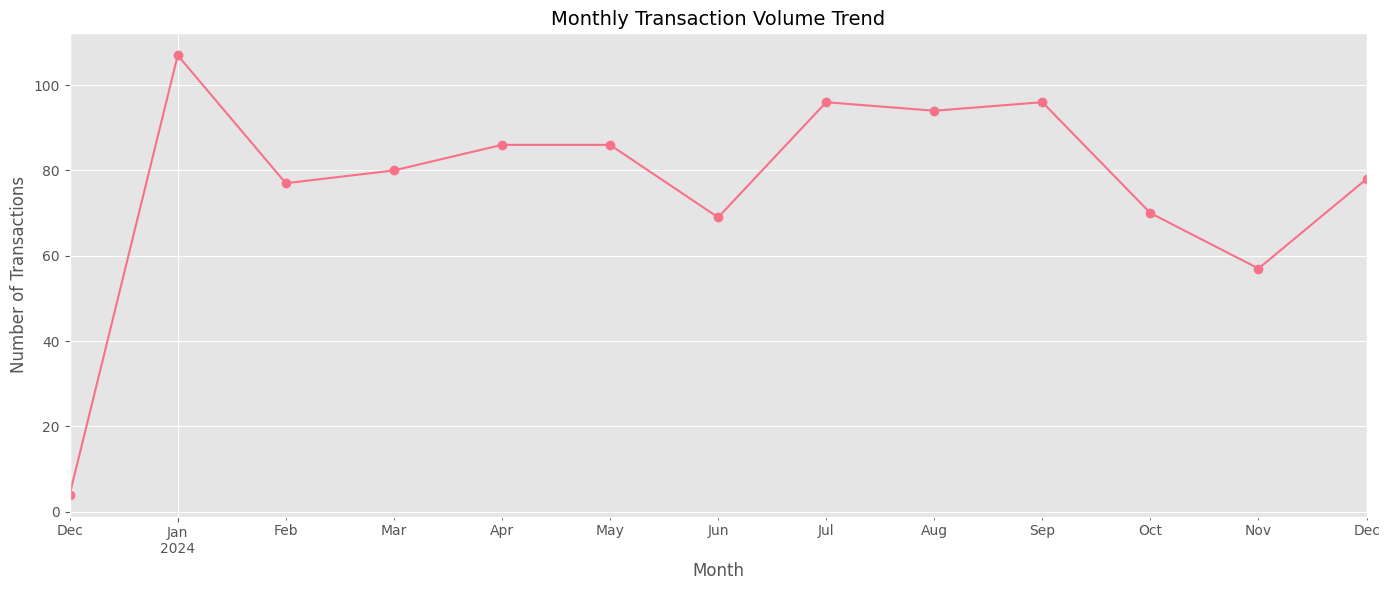

In [9]:

# Monthly transaction trend
plt.figure(figsize=(14, 6))
monthly_trend = full_data.groupby('TransactionYearMonth')['TransactionID'].nunique()
monthly_trend.plot(kind='line', marker='o')
plt.title('Monthly Transaction Volume Trend', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_trend.png')  
plt.show()

In [14]:

# Ensure TransactionYearMonth is in the correct format (if it's already a Period, skip conversion)
if not isinstance(full_data['TransactionYearMonth'].dtype, pd.PeriodDtype):
    full_data['TransactionYearMonth'] = pd.to_datetime(full_data['TransactionYearMonth'], format='%Y%m').dt.to_period('M')

# Group by SignupYear and TransactionYearMonth
cohort_data = full_data.groupby(['SignupYear', 'TransactionYearMonth']).agg(
    n_customers=('CustomerID', 'nunique')
).reset_index()

# Convert SignupYear to a Period (e.g., 2020 -> '2020-01')
cohort_data['SignupPeriod'] = cohort_data['SignupYear'].astype(str).apply(lambda x: pd.Period(x, freq='M'))

# Calculate cohort age (number of months between signup and transaction)
cohort_data['CohortAge'] = (cohort_data['TransactionYearMonth'] - cohort_data['SignupPeriod']).apply(lambda x: x.n)

print(cohort_data.head())

   SignupYear TransactionYearMonth  n_customers SignupPeriod  CohortAge
0        2022              2023-12            1      2022-01         23
1        2022              2024-01           24      2022-01         24
2        2022              2024-02           23      2022-01         25
3        2022              2024-03           22      2022-01         26
4        2022              2024-04           17      2022-01         27


In [15]:
# Pivot table for retention matrix
cohort_pivot = cohort_data.pivot_table(
    index='SignupYear',
    columns='CohortAge',
    values='n_customers',
    aggfunc='sum'
)

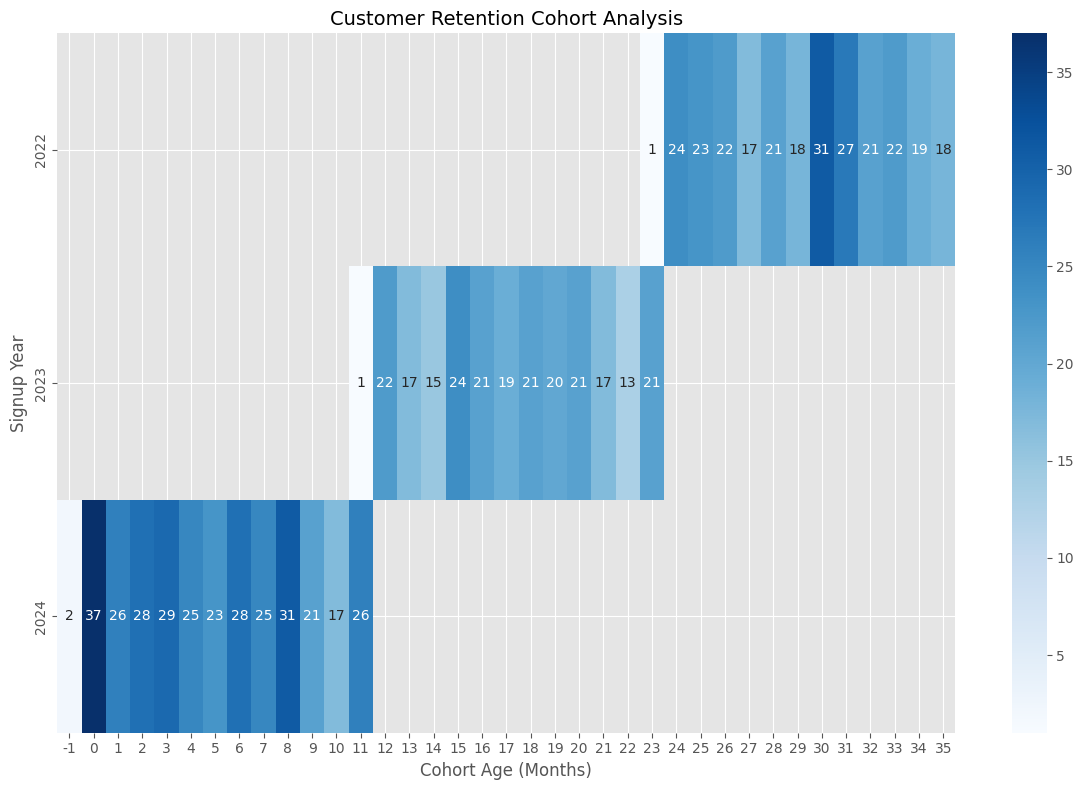

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Customer Retention Cohort Analysis', fontsize=14)
plt.xlabel('Cohort Age (Months)')
plt.ylabel('Signup Year')
plt.tight_layout()
plt.savefig('cohort_analysis.png')
plt.show()

#  Customer Analysis


In [18]:
# RFM Analysis
snapshot_date = full_data['TransactionDate'].max() + pd.DateOffset(days=1)
rfm = full_data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,
    'TransactionID': 'count',
    'TotalValue': 'sum'
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'TotalValue': 'MonetaryValue'
})

In [19]:
# RFM Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1))
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=range(1, 5))

rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], 4, labels=range(1, 5))


rfm['RFM_Score'] = rfm.R_Score.astype(str) + rfm.F_Score.astype(str) + rfm.M_Score.astype(str)




In [20]:
# Segment definitions
segments = {
    'Champions': rfm[rfm['RFM_Score'].isin(['444', '443', '434'])],
    'Loyal Customers': rfm[rfm['F_Score'] >= 3],
    'At Risk': rfm[rfm['R_Score'] <= 2],
    'Lost Customers': rfm[rfm['R_Score'] <= 1]
}


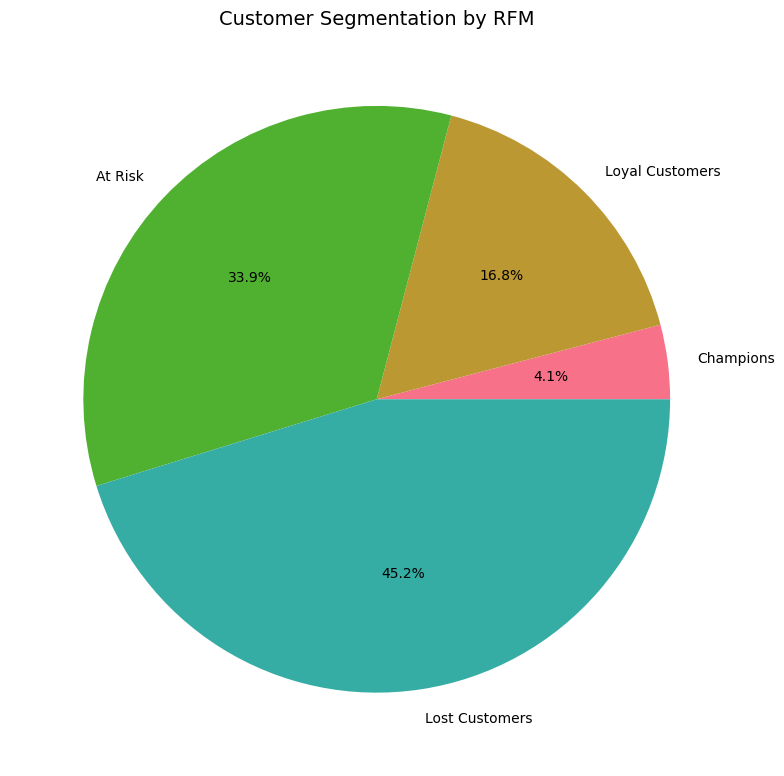

In [21]:

segment_counts = pd.Series({k: len(v) for k, v in segments.items()})
segment_counts.plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Customer Segmentation by RFM', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.savefig('rfm_segmentation.png')
plt.show()

#  Product Analysis


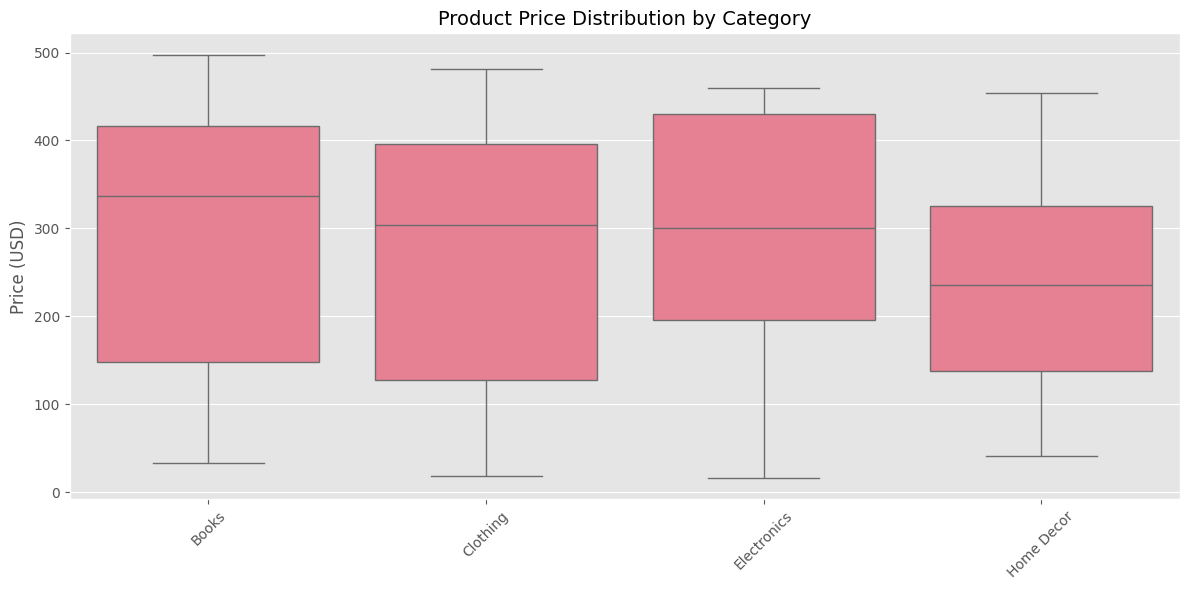

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Price_prod', data=full_data)
plt.title('Product Price Distribution by Category', fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.savefig('price_distribution.png')
plt.show()


In [24]:
# Price distribution analysis

# Pareto Analysis (Top 20% Products)
product_sales = full_data.groupby('ProductName').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum'
}).sort_values('TotalValue', ascending=False)

In [25]:
product_sales['CumulativePct'] = product_sales['TotalValue'].cumsum() / product_sales['TotalValue'].sum() * 100


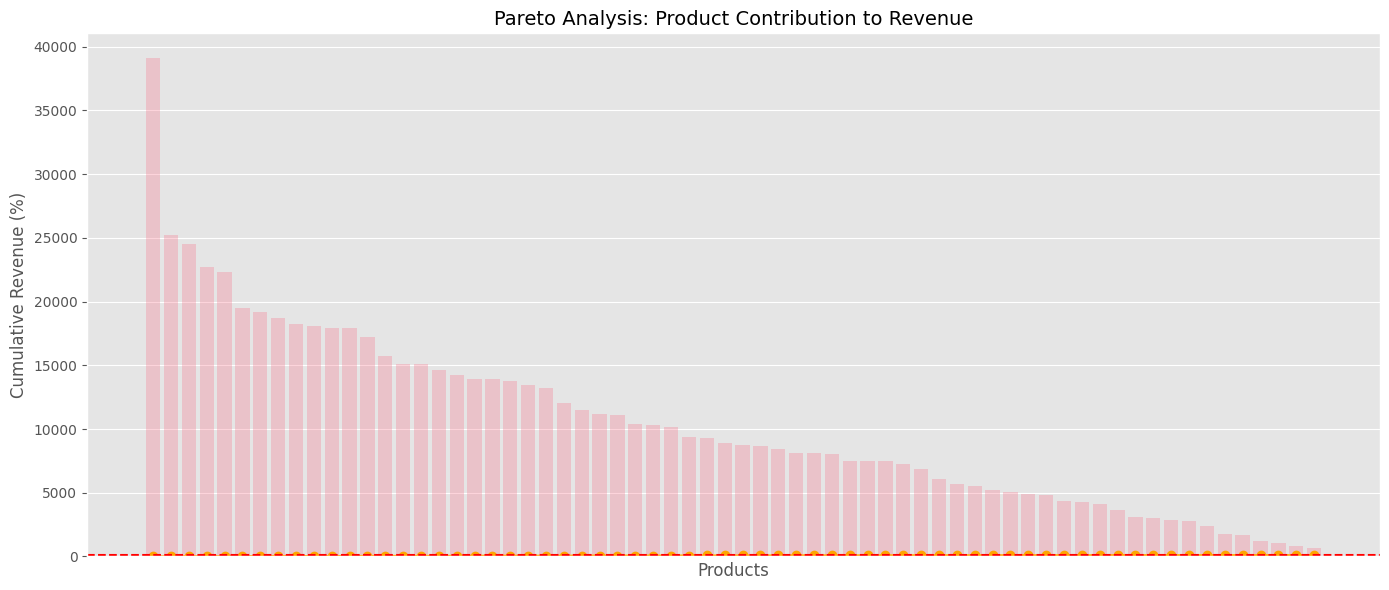

In [26]:
plt.figure(figsize=(14, 6))
ax = product_sales['CumulativePct'].plot(kind='line', marker='o', color='orange')
plt.bar(product_sales.index, product_sales['TotalValue'], alpha=0.3)
plt.axhline(80, color='red', linestyle='--')
plt.title('Pareto Analysis: Product Contribution to Revenue', fontsize=14)
plt.xlabel('Products')
plt.ylabel('Cumulative Revenue (%)')
plt.xticks([])
plt.grid(True)
plt.tight_layout()
plt.savefig('pareto_analysis.png')
plt.show()

#  Geographic Analysis


In [29]:

region_perf = full_data.groupby('Region').agg({
    'CustomerID': 'nunique',
    'TotalValue': ['sum', 'mean']
}).reset_index()
region_perf.columns = ['Region', 'UniqueCustomers', 'TotalRevenue', 'AvgOrderValue']

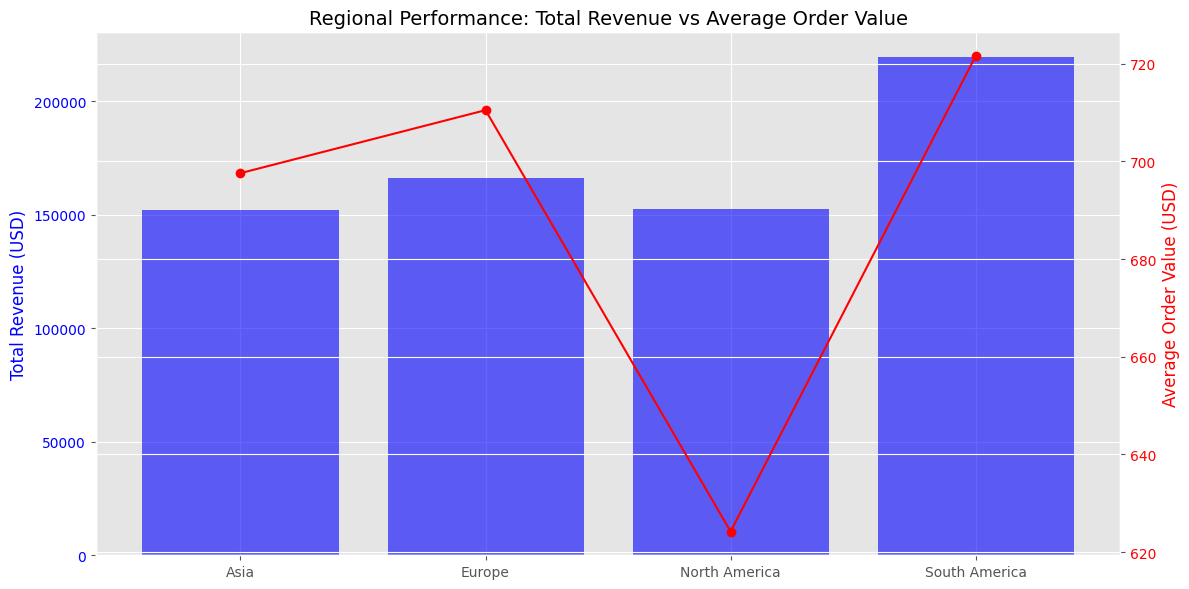

In [30]:


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(region_perf['Region'], region_perf['TotalRevenue'], alpha=0.6, color='blue')
ax1.set_ylabel('Total Revenue (USD)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(region_perf['Region'], region_perf['AvgOrderValue'], marker='o', color='red')
ax2.set_ylabel('Average Order Value (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Regional Performance: Total Revenue vs Average Order Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('regional_performance.png')
plt.show()
